In [1]:
from pathlib import Path
import pandas as pd
from datetime import timedelta
import requests
import yfinance as yf
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from xgboost import XGBClassifier
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
ipo_csv = pd.read_csv('IpoScoop.csv')
filtered_ipo=ipo_csv.drop(columns=["1st Day Close"])
filtered_ipo.set_index('Symbol',inplace=True)

<AxesSubplot:ylabel='Industry'>

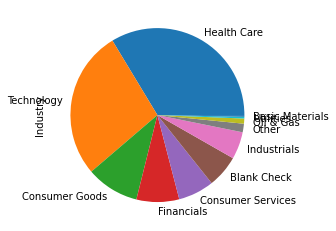

In [ ]:
sector_count = filtered_ipo["Industry"].value_counts()
sector_count.plot(kind="pie")

In [ ]:
filtered_ipo["Offer Date"]=pd.to_datetime(filtered_ipo["Offer Date"], infer_datetime_format=True)
filter_ipo=filtered_ipo.drop(["MTAL.U"])
filter_ipo.head()

,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,Return
Symbol,,,,,,,
JCSE,JE Cleantech Holdings Limited,Industrials,2022-04-22,3.8,$4.00,$19.00,375.00%
APLD,"Applied Blockchain, Inc.",Technology,2022-04-13,8.0,$5.00,$4.02,-19.60%
EE,"Excelerate Energy, Inc.",Oil & Gas,2022-04-13,16.0,$24.00,$24.20,0.83%
GNS,Genius Group Limited,Consumer Services,2022-04-12,3.3,$6.00,$6.23,3.83%
XPON,Expion360 Inc.,Industrials,2022-04-01,2.2,$7.00,$4.15,-40.71%


In [ ]:
ten_days = pd.to_timedelta(10,'days')
three_months = pd.to_timedelta(84,'days')
hundred_days = pd.to_timedelta(100,'days')
filter_ipo['T-10Days'] = filter_ipo['Offer Date']-ten_days
filter_ipo['T-90Days'] = filter_ipo['Offer Date']-three_months
filter_ipo['T+100Days'] = filter_ipo['Offer Date']+hundred_days

In [ ]:
filter_ipo['T-10Days'] = filter_ipo['T-10Days'].astype(str)
filter_ipo['T-90Days'] = filter_ipo['T-90Days'].astype(str)
filter_ipo['T+100Days'] = filter_ipo['T+100Days'].astype(str)

In [ ]:
for ticker in filter_ipo.index:
    data=yf.download("SPY",filter_ipo.loc[ticker,'T-90Days'], filter_ipo.loc[ticker,'T-10Days'],progress=True)
    spy_return = (data.iloc[-1,-2] - data.iloc[0,-2])/data.iloc[0,-2]
    filter_ipo.loc[ticker,'SPY 90D Return'] = spy_return
    data2=yf.download(ticker,filter_ipo.loc[ticker,'Offer Date'], filter_ipo.loc[ticker,'T+100Days'],progress=True)
    stock_return = (data2.iloc[-1,-2] - data2.iloc[0,-2])/data2.iloc[0,-2]
    filter_ipo.loc[ticker,'100 day Return'] = stock_return

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
display(filter_ipo)


,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,Return,T-10Days,T-90Days,T+100Days,SPY 90D Return,100 day Return
Symbol,,,,,,,,,,,,
JCSE,JE Cleantech Holdings Limited,Industrials,2022-04-22,3.8,$4.00,$19.00,375.00%,2022-04-12,2022-01-28,2022-07-31,-0.001501,-0.771053
APLD,"Applied Blockchain, Inc.",Technology,2022-04-13,8.0,$5.00,$4.02,-19.60%,2022-04-03,2022-01-19,2022-07-22,0.005705,-0.307217
EE,"Excelerate Energy, Inc.",Oil & Gas,2022-04-13,16.0,$24.00,$24.20,0.83%,2022-04-03,2022-01-19,2022-07-22,0.005705,0.005959
GNS,Genius Group Limited,Consumer Services,2022-04-12,3.3,$6.00,$6.23,3.83%,2022-04-02,2022-01-18,2022-07-21,-0.004738,-0.811475
XPON,Expion360 Inc.,Industrials,2022-04-01,2.2,$7.00,$4.15,-40.71%,2022-03-22,2022-01-07,2022-07-10,-0.043596,-0.547289
...,...,...,...,...,...,...,...,...,...,...,...,...
AGTI,"Agiliti, Inc.",Health Care,2021-04-23,26.3,$14.00,$20.16,44.00%,2021-04-13,2021-01-29,2021-08-01,0.115973,0.194512
IMPL,Impel NeuroPharma,Health Care,2021-04-23,5.3,$15.00,$6.11,-59.27%,2021-04-13,2021-01-29,2021-08-01,0.115973,-0.062667
SWIM,"Latham Group, Inc.",Consumer Goods,2021-04-23,20.0,$19.00,$12.01,-36.79%,2021-04-13,2021-01-29,2021-08-01,0.115973,0.001101


In [ ]:
# Encode Offer Date to week of year
for ticker in filter_ipo.index:
    filter_ipo.loc[ticker,'Offer Date'] = filter_ipo.loc[ticker,'Offer Date'].isocalendar()[1]

In [ ]:
# Create binary encoded column for whether or not stock saw positive gains after 100 days
returns_bin = []
for pct in filter_ipo['100 day Return']:
    if pct >= 0:
        returns_bin.append(1)
    else:
        returns_bin.append(0)
        
filter_ipo['100D Y/N'] = returns_bin

#Encoding "Industry" Column
le = LabelEncoder()
le.fit(filter_ipo["Industry"])
filter_ipo["Industry"] = le.transform(filter_ipo["Industry"])

# Drop unecessary date columns
filter_ipo.drop(columns=['T-10Days','T-90Days','T+100Days'], inplace=True)

In [ ]:
# Use glob to create categorized lists of Yahoo Finance CSV's for parsing
bs_list = glob.glob("*_annual_balance-sheet.csv")
cf_list = glob.glob("*_annual_cash-flow.csv")
af_list = glob.glob("*_annual_financials.csv")
list_of_lists = [bs_list,cf_list,af_list]

In [ ]:
# Clean and organize CSV
def step_1(frame):
    frame_df = frame.set_index('name')
    
    # Delete TTM column as this data may be more recent than date of IPO
    if 'ttm' in frame_df.columns: 
        frame_df.drop(columns = 'ttm',inplace=True)
    else:
        pass
    
    # Keep only latest annual financial data from year prior to IPO
    if len(frame_df) == 0:
        pass
    else:
        frame_df = frame_df.iloc[:,0]
    
    # Fill NaN's
        frame_df = pd.DataFrame(frame_df.fillna(0))
    
    # Transpose DataFrame
        frame_df = frame_df.T
    
    # Standardize index
        frame_df = frame_df.reset_index()
    
    #Remove '\t...' from column names
        frame_df.columns = frame_df.columns.str.strip()
    
        return frame_df

In [ ]:
#Create dataframe for CSV per respective category
def step_2(list):
    df = pd.DataFrame()
    
    # Loop through each list of YF Financials and clean CSV
    for file in list:
        
        # Read in CSV
        path = Path(file)
        csv = pd.read_csv(path, engine='python')
        
        # Clean CSV using step_1 function
        step = step_1(csv)
        
        # Add data from csv to df
        df = pd.concat([df,step], axis = 0)
        
        # Fill NaNs
        df = df.fillna(0)
        
        # Remove "\t" from column names
        df.columns = df.columns.str.strip()
        
        # Reset index
        df.reset_index(drop=True, inplace=True)
        
        # Drop useless column
        #df.drop(columns='index',inplace=True)
    
    # Loop through columns and drop columns that have 0 for more than 20% of the data therein
    for column in df.columns[1:]:
        zeros = (df[column]==0).sum()
        if zeros >= 0.8*len(df.index):
            df.drop(columns = column, inplace = True)
        else:
            pass
    
    return df

In [ ]:
# Create dataframe concatenated from respective categorical dataframes
def step_3(list):
    df = pd.DataFrame()
    tickers = []
    
    # Loop through each list of respective YF CSVs
    for l in list_of_lists:
        
        #Clean and concatenate CSV based on category
        frame = step_2(l)
        df = pd.concat([df,frame],axis=1)
    
    # Drop random NaN row?
    print(len(df))
    #df = df.dropna()
    
    #Clean and update index for syntax
    for name in bs_list:
        tickers.append(name[:4])

    df.index = tickers
    
    for x in df.index:
        if x[3] == '_':
             df.rename(index={x:x[:3]},inplace=True)
        elif x[2] == '_':
            df.rename(index={x:x[:2]},inplace=True)
        elif x[1] == '_':
            df.rename(index={x:x[:1]},inplace=True)
        else:
            pass
    
    return df

In [ ]:
#Running Functions and Compiling DFs
bz_df = step_3(list_of_lists)
bz_ipo_df = pd.concat([bz_df, filter_ipo],axis=1)
bz_ipo_df.drop(columns='Return', inplace=True)
bz_ipo_df = bz_ipo_df.dropna()
#bz_ipo_df.set_index('Industry',inplace=True)
#bz_ipo_df = bz_ipo_df.drop(columns='Symbol')
bz_ipo_df

0


,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,SPY 90D Return,100 day Return,100D Y/N
Symbol,,,,,,,,,
JCSE,JE Cleantech Holdings Limited,6,16,3.8,$4.00,$19.00,-0.001501,-0.771053,0
APLD,"Applied Blockchain, Inc.",9,15,8.0,$5.00,$4.02,0.005705,-0.307217,0
EE,"Excelerate Energy, Inc.",7,15,16.0,$24.00,$24.20,0.005705,0.005959,1
GNS,Genius Group Limited,3,15,3.3,$6.00,$6.23,-0.004738,-0.811475,0
XPON,Expion360 Inc.,6,13,2.2,$7.00,$4.15,-0.043596,-0.547289,0
...,...,...,...,...,...,...,...,...,...
AGTI,"Agiliti, Inc.",5,16,26.3,$14.00,$20.16,0.115973,0.194512,1
IMPL,Impel NeuroPharma,5,16,5.3,$15.00,$6.11,0.115973,-0.062667,0
SWIM,"Latham Group, Inc.",2,16,20.0,$19.00,$12.01,0.115973,0.001101,1


In [ ]:
bz_ipo_df.loc[:,'Industry'] = bz_ipo_df.loc[:,'Industry'].astype(str)
bz_ipo_df.loc[:,'100D Y/N'] = bz_ipo_df.loc[:,'100D Y/N'].astype(str)

In [ ]:
for column in bz_ipo_df.columns:
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].astype(str)
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace(',','').astype(float)

C:\Users\Straw Hat\Documents\Bootcamp\envs\dev\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: could not convert string to float: 'JE Cleantech Holdings Limited'

In [ ]:
# Drop 100 Day Returns column so that it doesn't wind up in training split
bz_ipo_df.drop(columns='100 day Return', inplace=True)

In [ ]:
bz_ipo_df['100D Y/N'].value_counts()

In [ ]:
bz_ipo_df.columns

In [ ]:
# Split and scale data
X = bz_ipo_df.iloc[:, 0:-1]
y = bz_ipo_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Use RandomOverSampler to balance data
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)